# Basic Prediction Methods

Here we compute the accuracy of prediction models on the same test set using basic methods, as a comparison to our prediction model. As before, we are using 12 months data to predict next 6 months.

In [1]:
import pandas as pd
import numpy as np

#For plotting
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from datetime import datetime

# Import the SimpleExpSmoothing object
from statsmodels.tsa.api import SimpleExpSmoothing
from statsmodels.tsa.arima.model import ARIMA

import random

In [80]:
# getting the same test set for accuracy
test = pd.read_csv('Test_data_pure.csv', index_col = 0)

In [64]:
def nonsmooth_values(data):
    nonsmooth = []
    for i in range(len(data)):
        game_data = data.iloc[i]
        months = pd.to_datetime(game_data.index)
        game = pd.DataFrame({'Month':months,'Data': game_data.astype(float)}).sort_values(by=['Month'])
        temp = game['Data'][game['Data'].first_valid_index():game['Data'].last_valid_index()].values
        nonsmooth.append(temp)
    return nonsmooth

In [127]:
# getting the first 18 months data
X = nonsmooth_values(test)
test_18truncated = np.zeros((len(test), 18))
test_12truncated = np.zeros((len(test), 12))
for i in range(len(test)):
    test_18truncated[i] = X[i][:18]
    test_12truncated[i] = X[i][:12]

Define the same metric for computing percentage error.

In [128]:
def rootmse(a, b):
    return np.sqrt(np.sum((a-b)**2))

In [137]:
def get_error(pred, test):
    error = 0
    for i in range(len(pred)):
        temp = test[i][12:]
        error = error + rootmse(pred,temp)/rootmse(temp,0)
    error = error / len(test)
    return error

# Naive Prediction

In [218]:
prediction = np.zeros((len(test_12truncated), 6))
for i in range(len(test)):
    prediction[i] = np.ones(6) * test_12truncated[i][11]

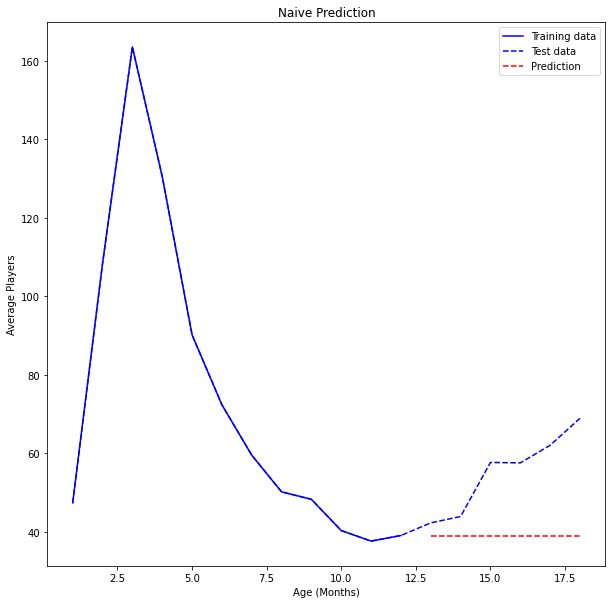

In [222]:
# Example
i = 1
plt.figure(figsize=(10,10))
plt.plot(range(1,13), test_12truncated[i], 'b', label = 'Training data')
plt.plot(range(1,19), test_18truncated[i], 'b--', label = 'Test data')
plt.plot(range(13, 19), prediction[i], 'r--', label = 'Prediction')
plt.xlabel('Age (Months)')
plt.ylabel('Average Players')
plt.title('Naive Prediction')
plt.legend(fontsize = 10)
plt.show()

In [138]:
get_error(prediction,test_18truncated)

# Exponential Smoothing Prediction

In [102]:
# Getting the smoothed curve for each game
# Ordered in increasing time order.

def smooth_values(data, smoothing_level=.5):
    smooth_timedata = []
    for i in range(len(data)):
        temp = data[i]
    
        # Fit exponential smoothing
        ses = SimpleExpSmoothing(temp)
        fit = ses.fit(smoothing_level=smoothing_level, optimized=False)

        smooth_timedata.append(fit.fittedvalues)
        
    return smooth_timedata

In [207]:
# Example
i = 2
smooth = smooth_values([test_12truncated[i]])[0]
prediction = np.ones(6) * smooth[11]

C:\Users\Joseph Leung\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


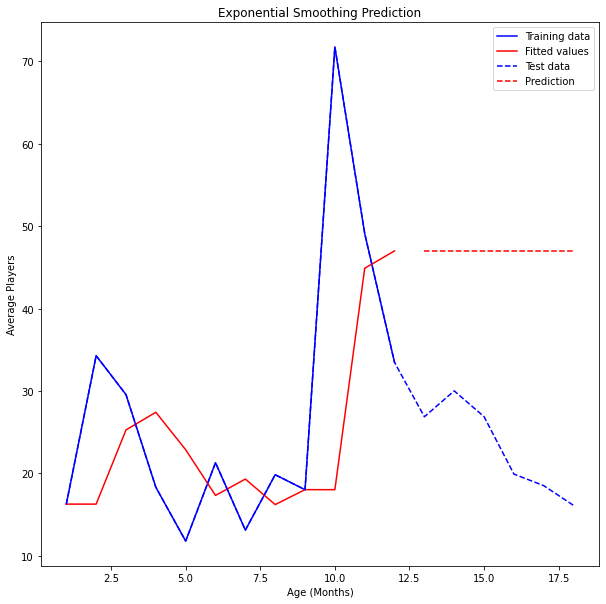

In [216]:
plt.figure(figsize=(10,10))
plt.plot(range(1,13), test_12truncated[i], 'b', label = 'Training data')
plt.plot(range(1,13), smooth, 'r', label = 'Fitted values')
plt.plot(range(1,19), test_18truncated[i], 'b--', label = 'Test data')
plt.plot(range(13, 19), prediction, 'r--', label = 'Prediction')
plt.xlabel('Age (Months)')
plt.ylabel('Average Players')
plt.title('Exponential Smoothing Prediction')
plt.legend(fontsize = 10)
plt.show()

In [147]:
# Computing error for different smoothing level

j=0
error_matrix = np.zeros((5,2))
for alpha in np.arange(0.2, 1.1, 0.2):
    smooth = smooth_values(test_12truncated, smoothing_level = alpha)
    pred = np.zeros((len(test_12truncated), 6))
    for i in range(len(test_12truncated)):
        pred[i] = np.ones(6) * smooth[i][11]
    error = get_error(pred, test_18truncated) / len(test_12truncated)
    error_matrix[j]=[alpha, error]
    j=j+1

In [148]:
error_matrix

array([[  0.2       , 104.14459036],
       [  0.4       , 145.93025905],
       [  0.6       , 163.56762285],
       [  0.8       , 171.20858483],
       [  1.        , 175.22315908]])

# ARIMA Prediction

In [224]:
# ARIMA smoothing
def arima_values(data, order=(1,0,1)):
    pred = []
    for i in range(len(data)):
        temp = data[i]
    
        # Fit ARIMA
        arima = ARIMA(temp, order = order)
        arima_fit = arima.fit()

        pred.append(arima_fit.forecast(6))
        
    return pred

In [225]:
# Example
i = 3
arima = ARIMA(test_12truncated[i], order = (1,0,1))
arima_fit = arima.fit()

In [237]:
arima_fit.forecast(6)

array([86.36706035, 79.6718475 , 78.73767766, 78.60733478, 78.5891483 ,
       78.58661078])

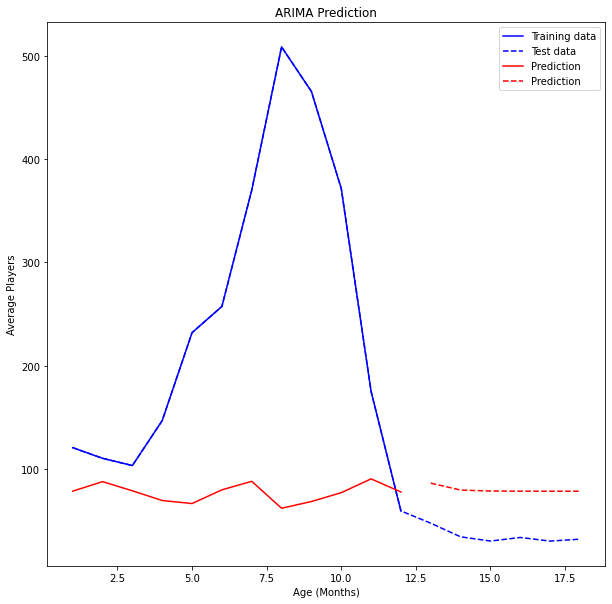

In [238]:
plt.figure(figsize=(10,10))
plt.plot(range(1,13), test_12truncated[i], 'b', label = 'Training data')
plt.plot(range(1,19), test_18truncated[i], 'b--', label = 'Test data')
plt.plot(range(1, 13), arima_fit.fittedvalues, 'r', label = 'Prediction')
plt.plot(range(13, 19), arima_fit.forecast(6), 'r--', label = 'Prediction')
plt.xlabel('Age (Months)')
plt.ylabel('Average Players')
plt.title('ARIMA Prediction')
plt.legend(fontsize = 10)
plt.show()

In [ ]:
# Computing error for different order

j=0
error_matrix = np.zeros((36,4))
for p in range(4):
    for d in range(3):
        for q in range(3):
            try:
                pred = arima_values(test_12truncated, order = (p,d,q))
                error = get_error(pred, test_18truncated) / len(test_12truncated)
                error_matrix[j]=[p, d, q, error]
                j=j+1
            except:
                print(p, d, q)

In [231]:
error_matrix

array([[  0.        ,   0.        ,   0.        ,  79.20677819],
       [  0.        ,   0.        ,   1.        ,  83.62336578],
       [  0.        ,   0.        ,   2.        ,  86.383261  ],
       [  0.        ,   1.        ,   0.        , 153.778601  ],
       [  0.        ,   1.        ,   1.        , 130.48665269],
       [  0.        ,   1.        ,   2.        , 116.27281596],
       [  0.        ,   2.        ,   0.        ,  87.04038476],
       [  0.        ,   2.        ,   1.        ,  84.46593963],
       [  0.        ,   2.        ,   2.        ,  93.55514897],
       [  1.        ,   0.        ,   0.        , 142.92524897],
       [  1.        ,   0.        ,   1.        , 114.54215363],
       [  1.        ,   0.        ,   2.        , 105.05331398],
       [  1.        ,   1.        ,   0.        , 115.22171721],
       [  1.        ,   1.        ,   1.        , 109.35674795],
       [  1.        ,   1.        ,   2.        ,  98.29939545],
       [  1.        ,   2

# Conclusion

One can see the errors here are very bad. The least average percentage error is around 76.9 * 100% = 7690 %, achieved by ARIMA with parameters (1,2,1).